In [73]:
import os
import pickle
import re
import numpy as np
import matplotlib.pyplot as plt

# Define the results directory
results_dir = "../results/num_initial_points"

# Initialize a dictionary to store the results grouped by num_initial_points
results_by_num_points = {
    5: [],
    10: [],
    15: [],
    20: [],
    25: [],
    30: []
}

# Define the batch ranges in order
batch_ranges = [(0, 250), (250, 500), (500, 750), (750, 1000)]

# Process files for each number of initial points and batch range in order
for num_points in results_by_num_points.keys():
    for start, end in batch_ranges:
        # Construct the expected filename pattern
        pattern = f"qm9_inversion_bispectrum_lmax_5_num_initial_points_{num_points}_batch_{start}_{end}.pkl"
        filepath = os.path.join(results_dir, pattern)
        
        # Check if the file exists
        if os.path.exists(filepath):
            try:
                with open(filepath, "rb") as f:
                    results = pickle.load(f)
                
                # Extract best_preds and add to the appropriate list
                if "best_preds" in results:
                    results_by_num_points[num_points].extend(results["best_preds"])
                    print(f"Loaded batch {start}-{end} for {num_points} initial points")
                else:
                    print(f"Warning: 'best_preds' not found in {pattern}")
            
            except Exception as e:
                print(f"Error loading {pattern}: {str(e)}")
        else:
            print(f"File not found: {pattern}")

# Print summary of results
for num_points, preds in results_by_num_points.items():
    print(f"Number of initial points: {num_points}, Number of predictions: {len(preds)}")

print("Dictionary with organized results created successfully!")

Loaded batch 0-250 for 5 initial points
Loaded batch 250-500 for 5 initial points
Loaded batch 500-750 for 5 initial points
Loaded batch 750-1000 for 5 initial points
Loaded batch 0-250 for 10 initial points
Loaded batch 250-500 for 10 initial points
Loaded batch 500-750 for 10 initial points
Loaded batch 750-1000 for 10 initial points
Loaded batch 0-250 for 15 initial points
Loaded batch 250-500 for 15 initial points
Loaded batch 500-750 for 15 initial points
Loaded batch 750-1000 for 15 initial points
Loaded batch 0-250 for 20 initial points
Loaded batch 250-500 for 20 initial points
Loaded batch 500-750 for 20 initial points
Loaded batch 750-1000 for 20 initial points
Loaded batch 0-250 for 25 initial points
Loaded batch 250-500 for 25 initial points
Loaded batch 500-750 for 25 initial points
Loaded batch 750-1000 for 25 initial points
Loaded batch 0-250 for 30 initial points
Loaded batch 250-500 for 30 initial points
Loaded batch 500-750 for 30 initial points
Loaded batch 750-1000 

In [74]:
with open('../data/qm9_local_envs_10000.pkl', 'rb') as f:
    local_envs = pickle.load(f)

local_envs = local_envs[:1000]

print(f"Number of local environments: {len(local_envs)}")

Number of local environments: 1000


In [75]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_dir = os.path.join(project_root, 'src')
sys.path.append(src_dir)
import spectra as spectra
from utils.plotters import visualize_signal
from utils.alignment import sample_uniform_quaternion, find_best_random_quaternion, align_signals, choose_best_quaternion, loss_fn, quaternion_rotation_distance, rotate_points_quaternion, point_distance, find_best_random_quaternions
from utils.geometries import trigonal_plane, tetrahedron, trigonal_bipyramid
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
import numpy as np
from scipy.spatial.transform import Rotation
import itertools


def align_predicted_geometry(true_geometry: np.ndarray,
                             predicted_geometry: np.ndarray
                            ) -> tuple[np.ndarray, float]:
    """
    Aligns `predicted_geometry` onto `true_geometry` using only a rigid-body rotation.
    Points are first sorted by distance from the origin, normalized to unit radius,
    then each pair of corresponding direction‐vectors is scaled by a different
    random weight (to break any geometric symmetry) before computing the optimal
    rotation. Assumes both inputs are centered at the origin.

    Parameters
    ----------
    true_geometry : (N, 3) array_like
        Reference point cloud, centered at the origin.
    predicted_geometry : (N, 3) array_like
        Point cloud to align, also centered.

    Returns
    -------
    aligned_predicted : (N, 3) ndarray
        The `predicted_geometry` rotated to best match `true_geometry`.
    rmsd : float
        The RMSD between the (weighted) direction‐vectors after optimal alignment.
    """
    # Convert inputs
    true_pts = np.asarray(true_geometry, dtype=float)
    pred_pts = np.asarray(predicted_geometry, dtype=float)
    if true_pts.shape != pred_pts.shape or true_pts.shape[1] != 3:
        raise ValueError("Both inputs must have shape (N, 3)")

    # Compute norms (radii) without sorting
    true_radii = np.linalg.norm(true_pts, axis=1)
    pred_radii = np.linalg.norm(pred_pts, axis=1)
    
    # Normalize to unit vectors directly without reordering
    true_dirs = true_pts / true_radii[:, None]
    pred_dirs = pred_pts / pred_radii[:, None]    

    # Generate a different random weight for each point to break symmetry
    # (e.g. uniform on [0,1) or any other distribution)
    weights = np.random.rand(true_dirs.shape[0], 1)

    # Scale both sets by the same per-point weights
    true_weighted = true_dirs * weights
    pred_weighted = pred_dirs * weights

    # Compute optimal rotation on weighted directions
    rot, rmsd = Rotation.align_vectors(true_weighted, pred_weighted)

    # Apply rotation back to the original predicted points
    pred_rotated = rot.apply(pred_pts)

    return pred_rotated, rmsd


def alignment_mae(true_geometry, predicted_geometry):

    if len(true_geometry) != len(predicted_geometry):
        return np.nan

    # Try all permutations of the predicted geometry and select the one with lowest RMSD
    best_error = float('inf')
    best_aligned = None
    
    # Get all permutations of indices
    n_points = predicted_geometry.shape[0]
    for perm in itertools.permutations(range(n_points)):
        perm_predicted = predicted_geometry[list(perm)]
        aligned, _ = align_predicted_geometry(true_geometry, perm_predicted)
        error = jnp.mean(jnp.linalg.norm(aligned - true_geometry, axis=1))
        if error < best_error:
            best_error = error
            best_aligned = aligned

    return best_error

In [76]:
import e3nn_jax as e3nn
import jax
import jax.numpy as jnp
import chex
from tqdm import tqdm
import numpy as np


LMAX = 5


def sum_of_diracs(
    vectors: chex.Array, 
    lmax: int, 
    values: chex.Array = None
) -> e3nn.IrrepsArray:
    """
    Given a set of vectors, computes the sum of Dirac delta functions.

    Parameters:
        vectors (chex.Array): Input array of vectors.
        lmax (int): Maximum degree of spherical harmonics.
        values (chex.Array, optional): Values at each vector. 
            If not provided, the norm of each vector is used.

    Returns:
        e3nn.IrrepsArray: The sum of Dirac delta functions.
    """
    if values is None:
        values = jnp.linalg.norm(vectors, axis=1)
    return e3nn.sum(e3nn.s2_dirac(vectors, lmax, p_val=1, p_arg=-1) * values[:, None], axis=0)


def bispectrum(x: e3nn.IrrepsArray) -> e3nn.IrrepsArray:
    """
    Computes the bispectrum of an array of irreducible representations.

    Parameters:
        x (e3nn.IrrepsArray): Input array of irreps.

    Returns:
        e3nn.IrrepsArray: The bispectrum of the input array.
    """
    rtp = e3nn.reduced_symmetric_tensor_product_basis(x.irreps, 3, keep_ir=['0o', '0e'])
    return e3nn.IrrepsArray(rtp.irreps, jnp.einsum("i,j,k,ijkz->z", x.array, x.array, x.array, rtp.array)).array


@jax.jit
def compute_bispectrum(env):
    """Compute bispectrum for an (M×3) array, zeros allowed."""
    bis = bispectrum(sum_of_diracs(env, LMAX)) 
    normalized_bispectrum = bis / jnp.linalg.norm(bis)
    return normalized_bispectrum

In [77]:
alignment_errors = {num_initial_points: [] for num_initial_points in results_by_num_points.keys()}
for num_initial_points in results_by_num_points.keys():
    mismatch_count = 0
    for index in range(len(results_by_num_points[num_initial_points])):
        if len(local_envs[index]) != len(results_by_num_points[num_initial_points][index]):
            mismatch_count += 1
        else:
            alignment_errors[num_initial_points].append(alignment_mae(local_envs[index], results_by_num_points[num_initial_points][index]))
        
    print(f"Mismatch count for {num_initial_points}: {mismatch_count}")
    print(f"Percentage of mismatches: {(mismatch_count / len(results_by_num_points[num_initial_points])) * 100}%")


/var/folders/7c/7cx32s8x1x32j9xw0z_x3y980000gn/T/ipykernel_84852/1288273720.py:65: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rot, rmsd = Rotation.align_vectors(true_weighted, pred_weighted)


Mismatch count for 5: 15
Percentage of mismatches: 1.5%
Mismatch count for 10: 0
Percentage of mismatches: 0.0%
Mismatch count for 15: 0
Percentage of mismatches: 0.0%
Mismatch count for 20: 0
Percentage of mismatches: 0.0%
Mismatch count for 25: 3
Percentage of mismatches: 0.3%
Mismatch count for 30: 1
Percentage of mismatches: 0.1%


In [108]:
len(alignment_errors[5])

985

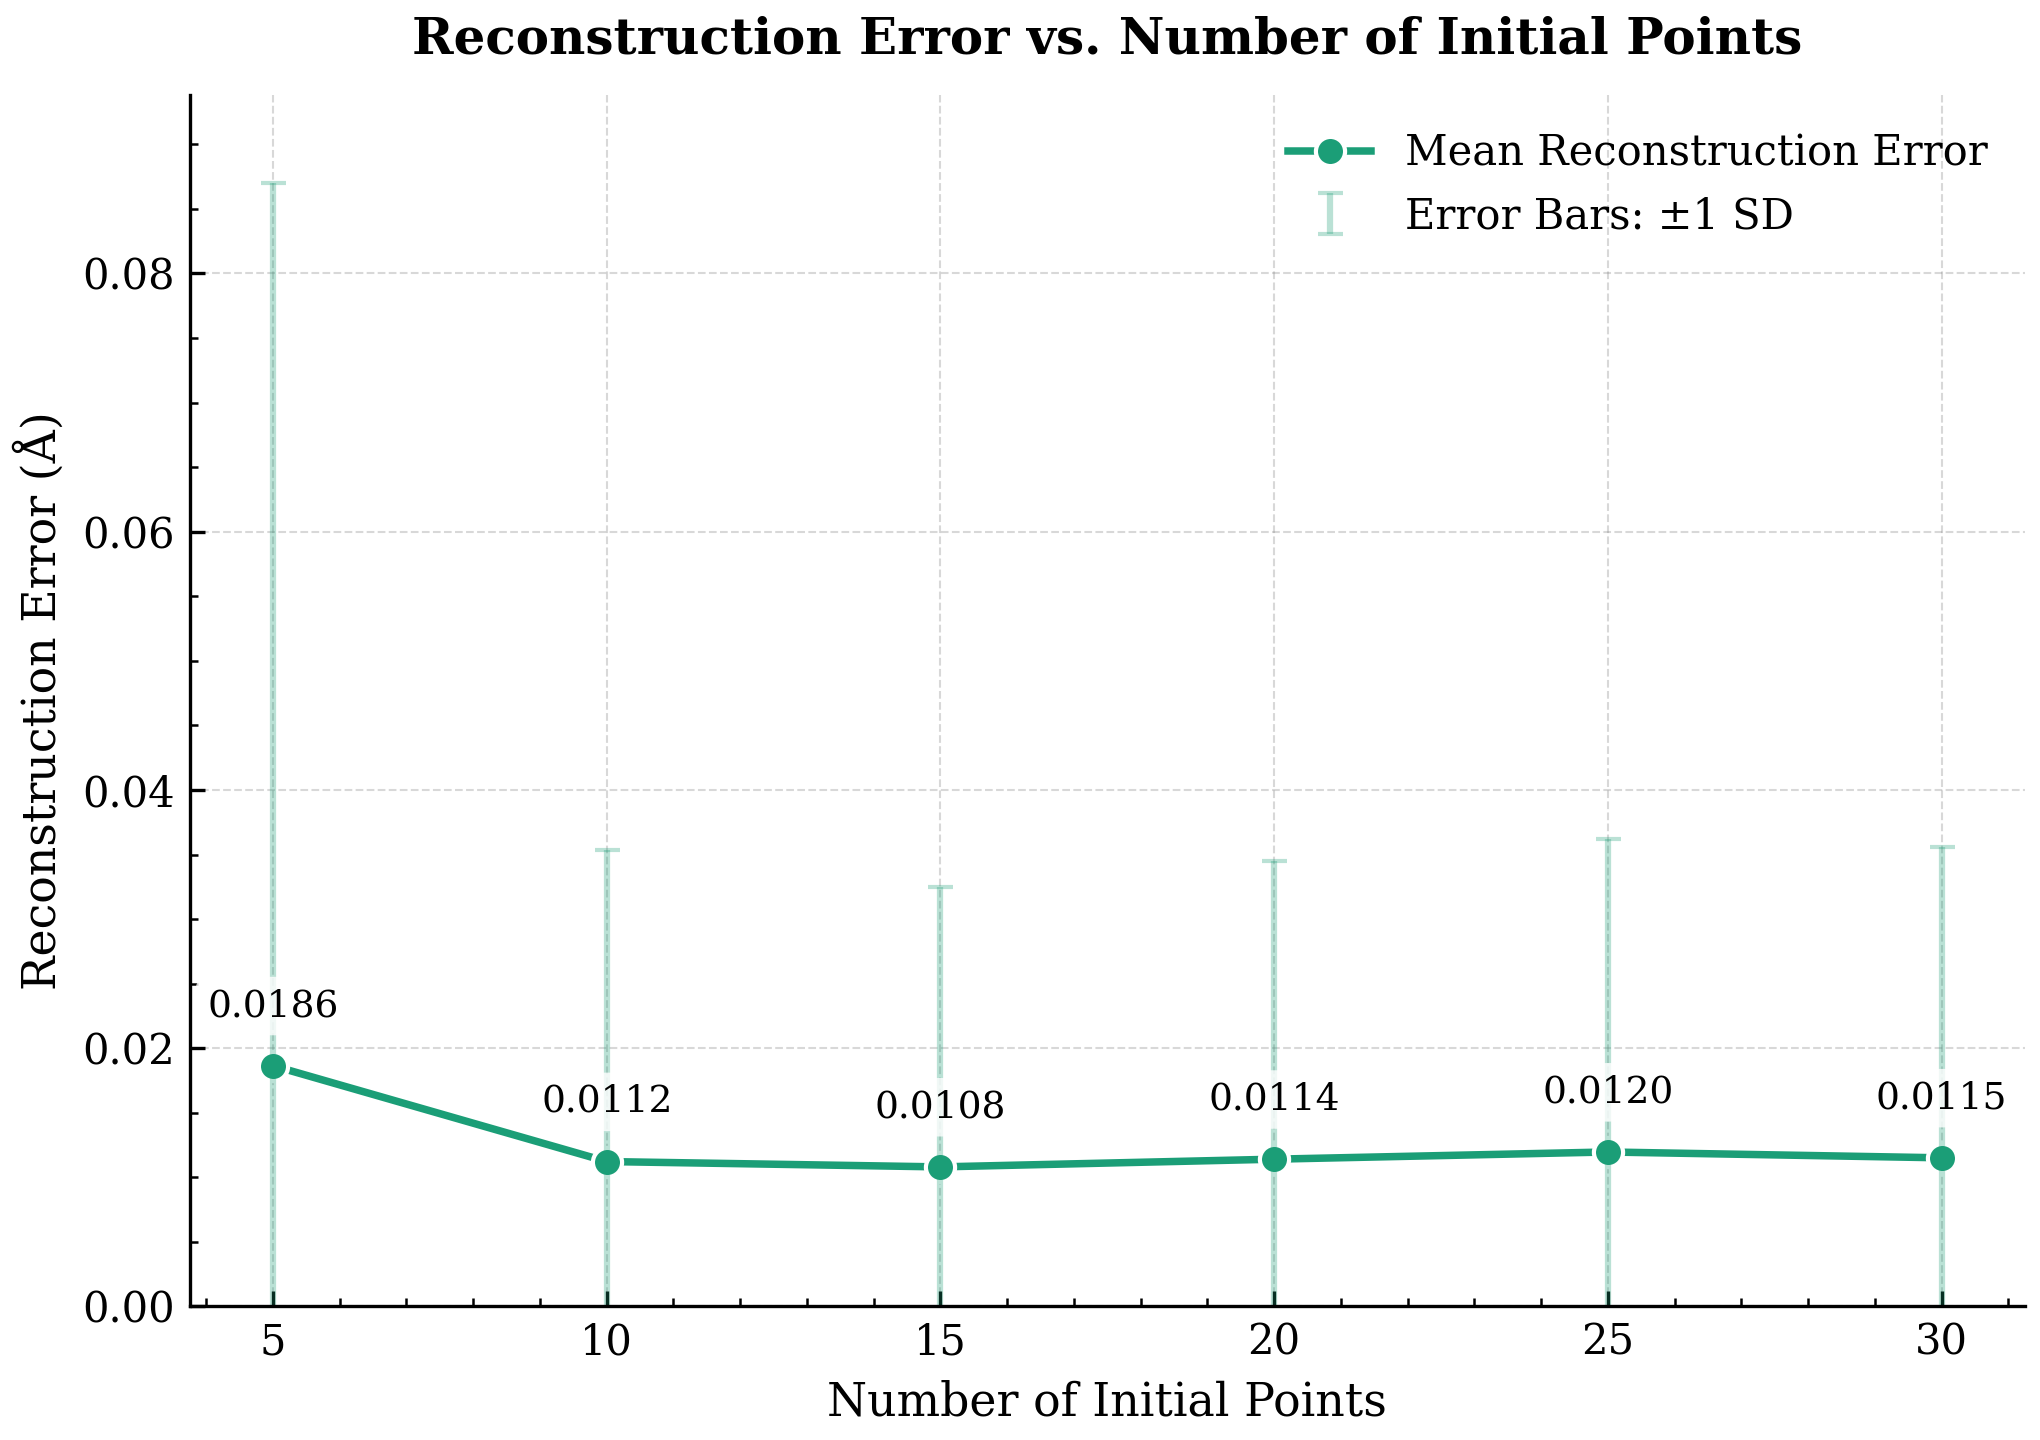

In [111]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

# Set publication-quality plot style
plt.rcParams.update({
    'text.usetex': False,  # Don't use LaTeX for text rendering
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman', 'DejaVu Serif', 'Times New Roman'],
    'mathtext.fontset': 'cm',  # Still use Computer Modern for math
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 300,
    'savefig.dpi': 600,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.05,
    'axes.linewidth': 0.8,
    'grid.linewidth': 0.6,
    'lines.linewidth': 1.5,
    'lines.markersize': 5,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'xtick.minor.width': 0.6,
    'ytick.minor.width': 0.6,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 3.5,
    'ytick.major.size': 3.5,
    'xtick.minor.size': 2.0,
    'ytick.minor.size': 2.0,
    'axes.axisbelow': True,
    'axes.grid': False,
})

# Extract the number of initial points and calculate statistics
num_points = sorted(alignment_errors.keys())
mean_errors = [np.mean(alignment_errors[n]) for n in num_points]

# Use a colorblind-friendly color
color = '#1b9e77'  # Green from ColorBrewer2.org palette

# Create the figure with one plot
fig, ax = plt.figure(figsize=(7, 5)), plt.gca()

# Plot the data with enhanced styling
ax.plot(num_points, mean_errors, marker='o', linestyle='-', 
        linewidth=1.8, markersize=7, markeredgewidth=1.0,
        color=color, markerfacecolor=color, markeredgecolor='white',
        label='Mean Reconstruction Error')

# Calculate standard deviation for error bars
std_errors = [np.std(alignment_errors[n]) for n in num_points]
ax.errorbar(num_points, mean_errors, yerr=std_errors, fmt='none', 
            ecolor=color, alpha=0.3, capsize=3)

# Add annotations for each mean value with 4 decimal places
for i, (x, y) in enumerate(zip(num_points, mean_errors)):
    formatted_mean = f"{y:.4f}"  # Format to 4 decimal places
    ax.annotate(formatted_mean, 
                xy=(x, y),
                xytext=(0, 10),  # Position 10 points above the data point
                textcoords="offset points",
                ha='center',  # Horizontally centered
                va='bottom',  # Bottom aligned with offset point
                fontsize=9,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.8))

# Enhance axis formatting
ax.grid(True, linestyle='--', alpha=0.3, color='gray', linewidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

# Format labels using matplotlib's built-in math renderer
ax.set_xlabel('Number of Initial Points', fontweight='normal')
ax.set_ylabel('Reconstruction Error (Å)', fontweight='normal')
ax.set_title('Reconstruction Error vs. Number of Initial Points', fontweight='bold', pad=10)

# Set y-axis to start at 0
ax.set_ylim(bottom=0)

# Add legend specifying standard deviation
labels = ['Mean Reconstruction Error', 'Error Bars: ±1 SD']
ax.legend(labels, loc='upper right', frameon=False)

# Adjust layout and save
plt.tight_layout()
plt.savefig('alignment_error_plot.pdf', dpi=600, bbox_inches='tight')
plt.savefig('alignment_error_plot.png', dpi=600, bbox_inches='tight')

plt.show()

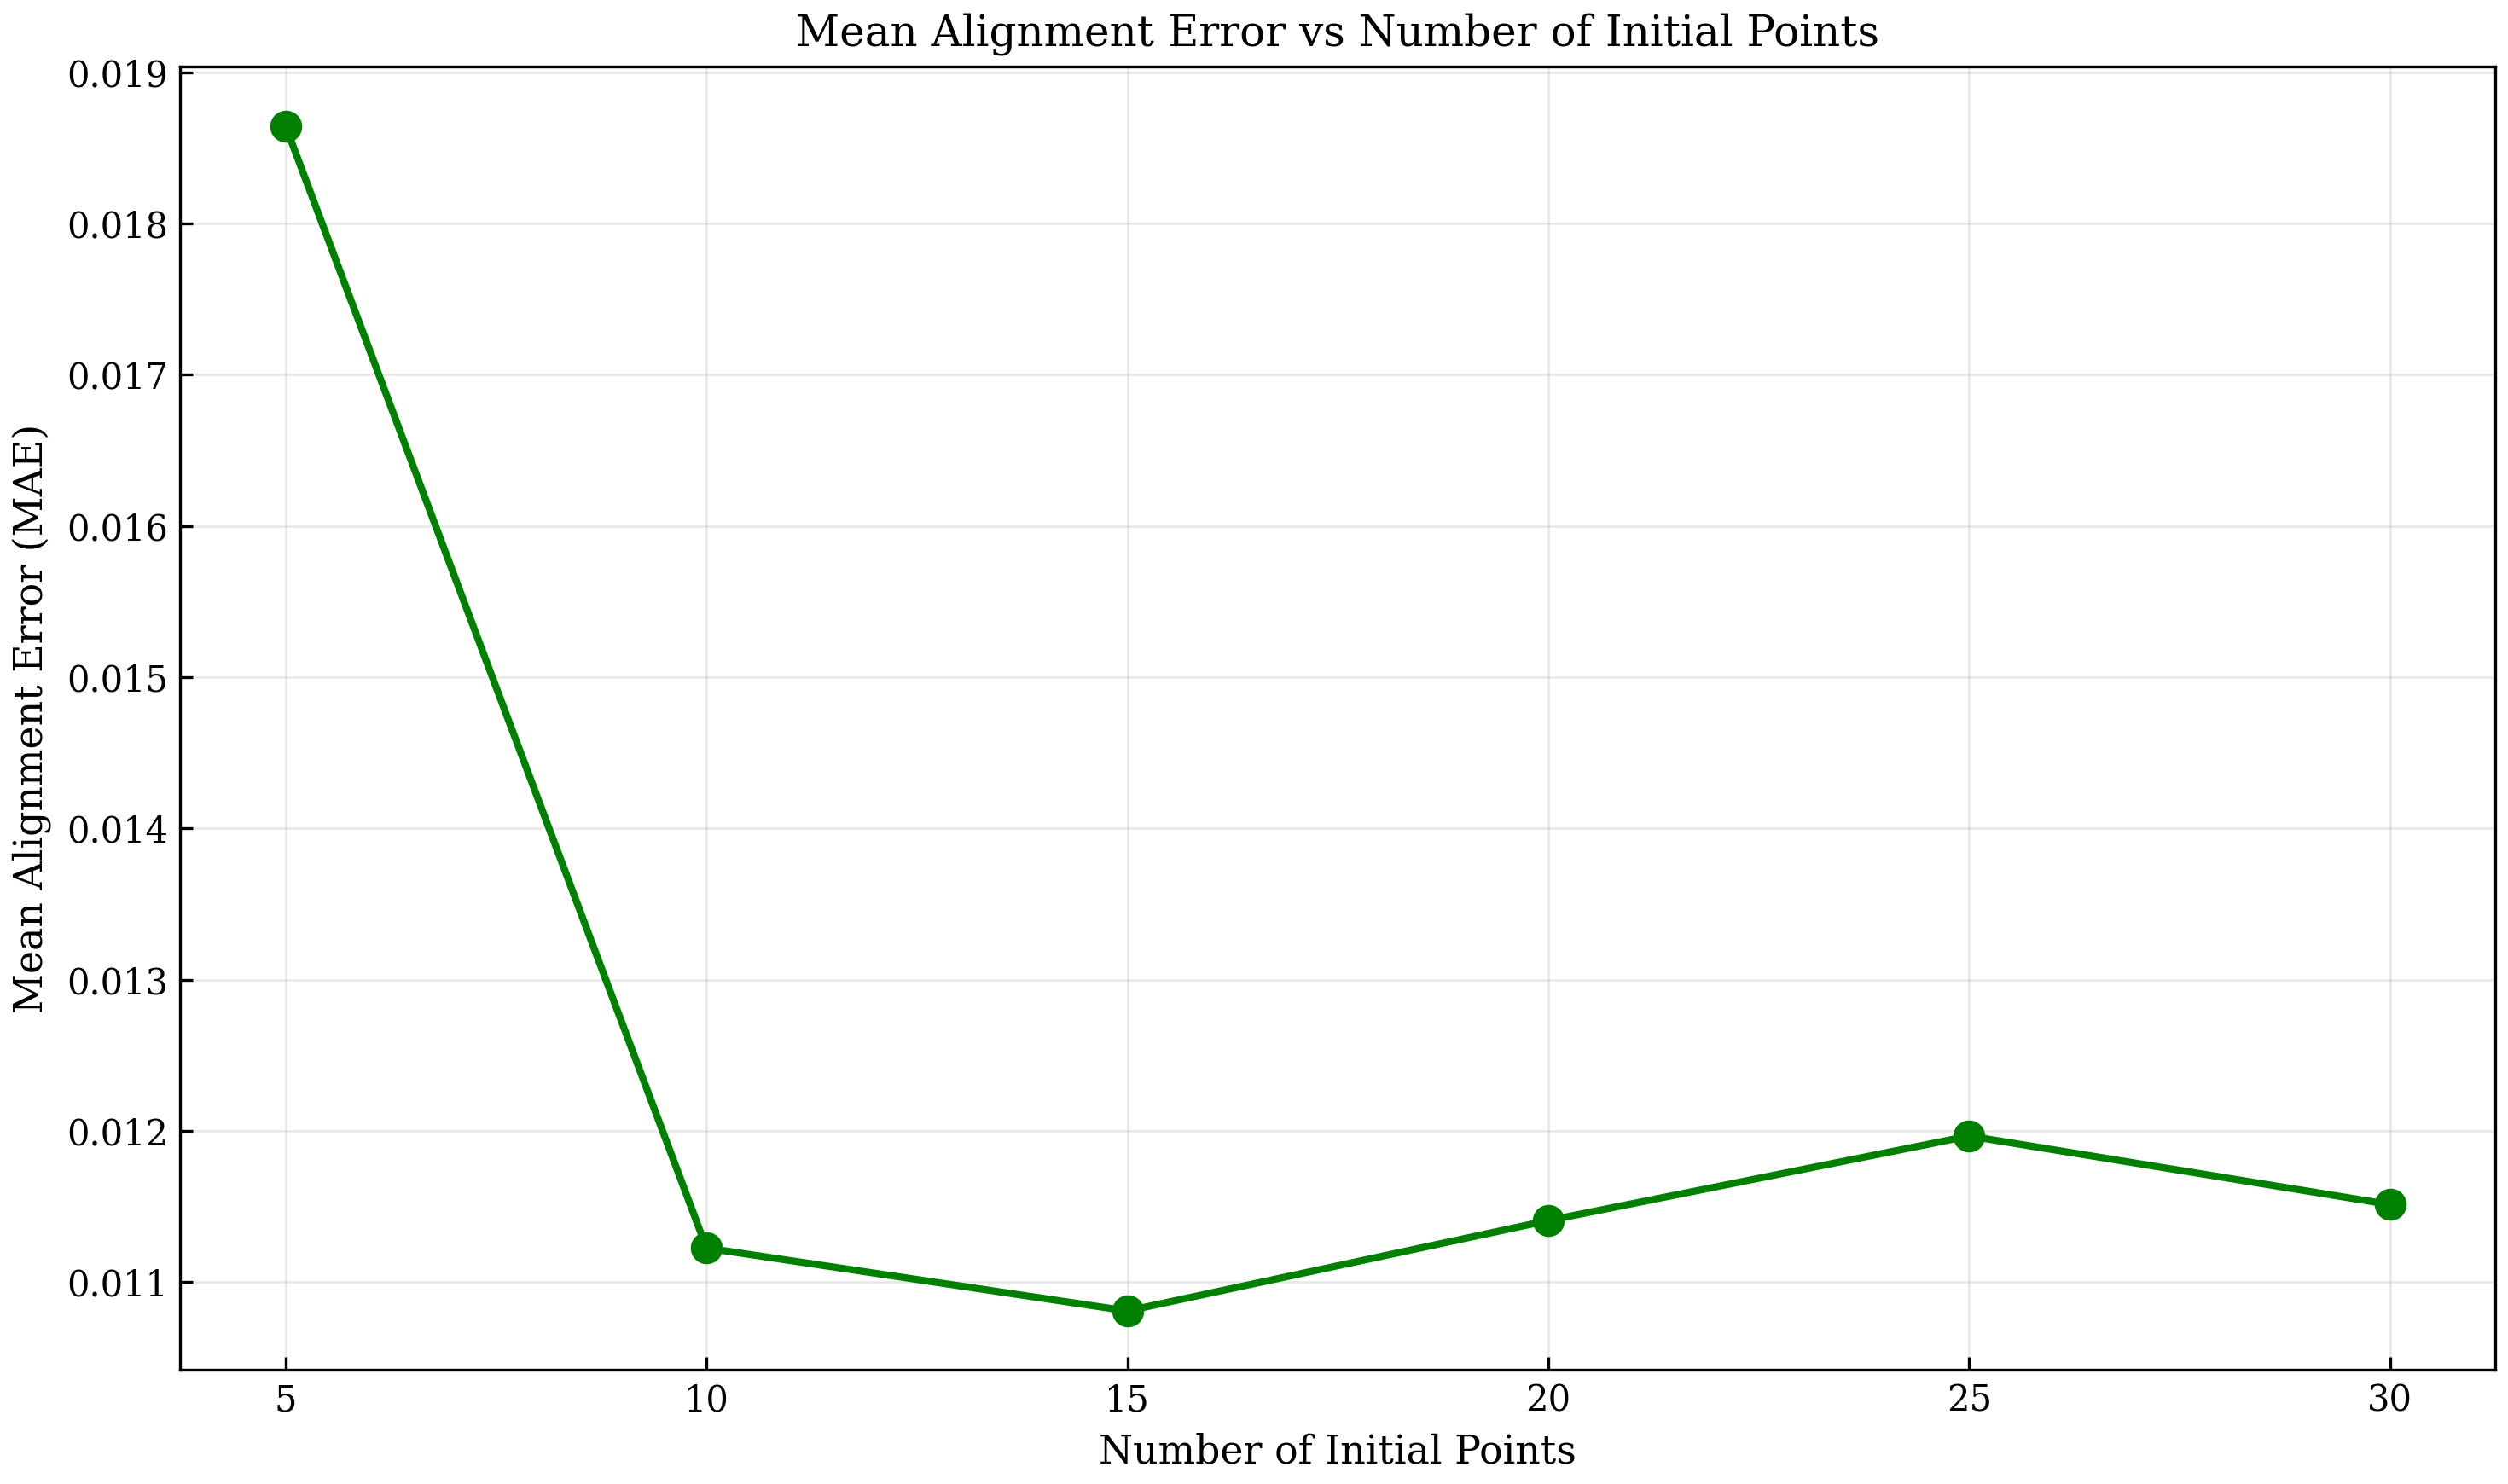

In [89]:
# Calculate statistics for alignment errors by number of initial points
import matplotlib.pyplot as plt
import numpy as np

# Extract the number of initial points and calculate statistics
num_points = sorted(alignment_errors.keys())
mean_errors = [np.mean(alignment_errors[n]) for n in num_points]

# Create a simple plot with just the mean
plt.figure(figsize=(10, 6))
plt.plot(num_points, mean_errors, 'o-', color='green', linewidth=2, markersize=8)
plt.xlabel('Number of Initial Points')
plt.ylabel('Mean Alignment Error (MAE)')
plt.title('Mean Alignment Error vs Number of Initial Points')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

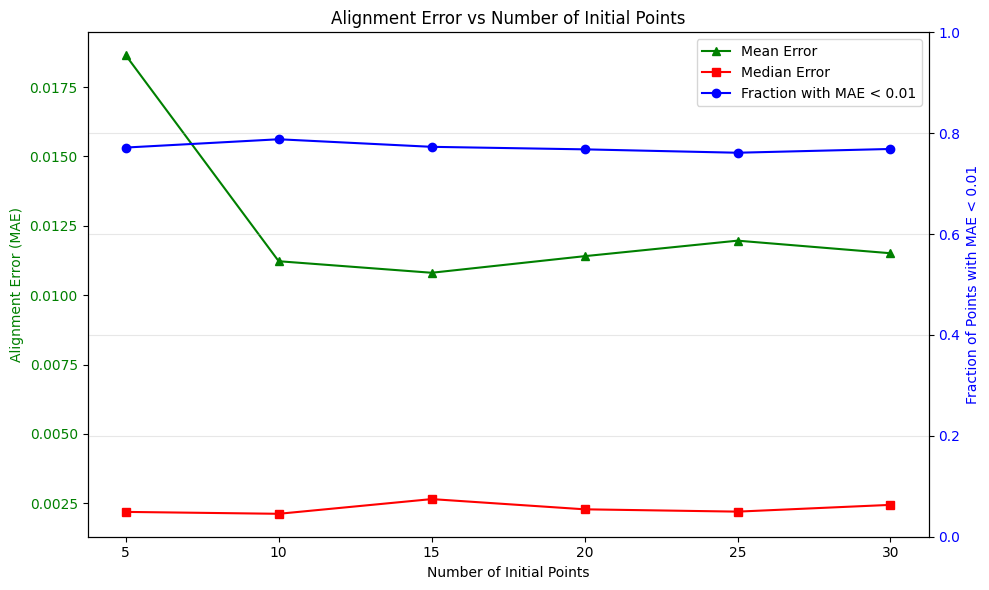

In [78]:
# Calculate statistics for alignment errors by number of initial points
import matplotlib.pyplot as plt
import numpy as np

# Extract the number of initial points and calculate statistics
num_points = sorted(alignment_errors.keys())
max_errors = [np.max(alignment_errors[n]) for n in num_points]
median_errors = [np.median(alignment_errors[n]) for n in num_points]
mean_errors = [np.mean(alignment_errors[n]) for n in num_points]

# Calculate fraction of points with MAE < 0.01
fraction_below_threshold = [np.mean(np.array(alignment_errors[n]) < 0.01) for n in num_points]

# Create the plot with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary y-axis for mean and median errors
color1 = 'green'
color3 = 'red'
ax1.plot(num_points, mean_errors, '^-', label='Mean Error', color=color1)
ax1.plot(num_points, median_errors, 's-', label='Median Error', color=color3)
ax1.set_xlabel('Number of Initial Points')
ax1.set_ylabel('Alignment Error (MAE)', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# Secondary y-axis for fraction below threshold
ax2 = ax1.twinx()
color2 = 'blue'
ax2.plot(num_points, fraction_below_threshold, 'o-', label='Fraction with MAE < 0.01', color=color2)
ax2.set_ylabel('Fraction of Points with MAE < 0.01', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(0, 1)  # Set y-axis limits for fraction

# Add legend for both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

plt.title('Alignment Error vs Number of Initial Points')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()